# Test Set Results for the MET Dataset

This notebook provides the code that generates the restorated images from the MET test dataset. These were the paintings with naturally occuring damage, so they were not included in the training process.

The damage masks were generated using K-Means clustering. The code for the mask generating process can be found in the GenerateMasks.ipynb

In [ ]:
# install necessary packages 
!pip install accelerate
!pip install transformers
!pip install diffusers
!pip install noise
!pip install bitsandbytes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 15.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl siz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
from torch import autocast
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from diffusers import StableDiffusionInpaintPipeline

# load in model
model_path = "drive/MyDrive/stat222/perlin_100_fine_tune_random_crop"

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")
g_cuda = None

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
# set up hyperparameters for prediction
transform = transforms.Compose([
                        transforms.Resize(512),
                        transforms.CenterCrop(512)
                    ])

prompt = "two sks people in sks painting from temple wall" 
negative_prompt = "" 
num_samples = 4 
guidance_scale = 10 # this is a number that tells the model how much weight to give to your prompt
num_inference_steps = 100 # this controls the number of denoising steps in the diffusion process
height = 512 
width = 512 

mask_dir = 'drive/MyDrive/met_data/facsimiles/masks/subsection_masks'
image_dir = 'drive/MyDrive/met_data/facsimiles/test/'
masks = os.listdir(mask_dir)

# create matplotlib figure
n = len(masks)
ncols = 2 + num_samples

fig, axes = plt.subplots(nrows=n, ncols=ncols, figsize=(15, 3*n))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Add column titles to the figure
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Mask")
axes[0, 2].set_title("Model Reconstruction")

for i, path in enumerate(masks):
  init_image = Image.open(os.path.join(image_dir, path))

  mask_image = Image.open(os.path.join(mask_dir, path))

  init_image = transform(init_image)
  mask_image = transform(mask_image)

  with autocast("cuda"), torch.inference_mode():
      images = pipe(
          prompt,
          image=init_image, 
          mask_image=mask_image,
          height=height,
          width=width,
          negative_prompt=negative_prompt,
          num_images_per_prompt=num_samples,
          num_inference_steps=num_inference_steps,
          guidance_scale=guidance_scale,
          generator=g_cuda
      ).images

  # add images to figure
  axes[i, 0].imshow(init_image)
  axes[i, 0].axis("off")
  axes[i, 1].imshow(mask_image)
  axes[i, 1].axis("off")

  for j, img in enumerate(images):
    axes[i, j + 2].imshow(img)
    axes[i, j + 2].axis("off")


In [ ]:
# save figure

plt.savefig('drive/MyDrive/stat222/figures/full_MET_test_set.png')

<Figure size 640x480 with 0 Axes>

In [7]:
import torch

# set seed for reproducability
# torch.set_seed sets seed on CPU and GPU
torch.manual_seed(123)
torch.manual_seed(111)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

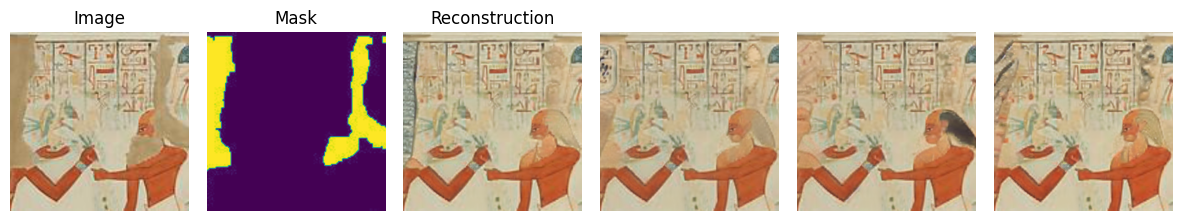

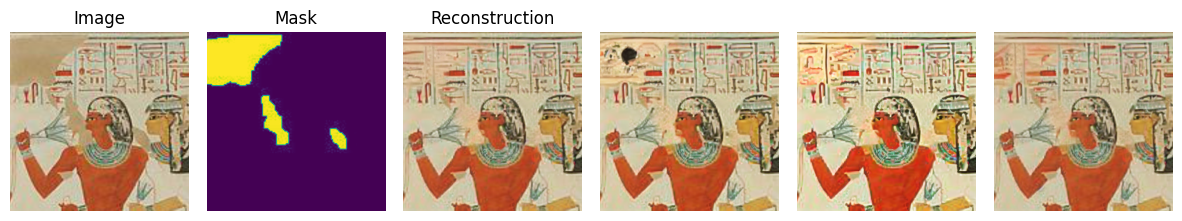

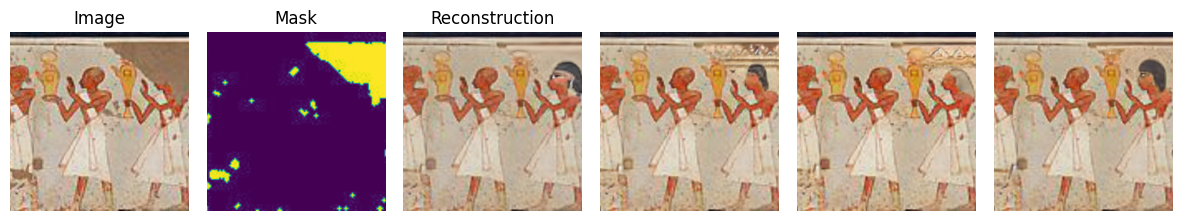

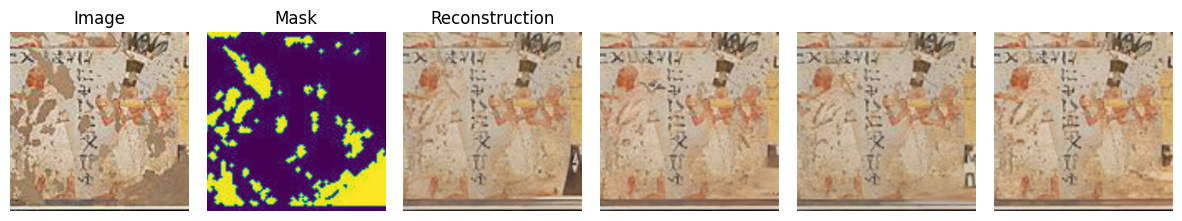

In [ ]:
# repeat for certain sections at high resolution

high_res_files = [masks[i] for i in range(len(masks)) if i in [0,2,7,9]]

for i, path in enumerate(high_res_files):
  # create matplotlib figure
  ncols = 2 + num_samples

  fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 3))
  plt.subplots_adjust(wspace=0.1, hspace=0.1)

  # Add column titles to the figure
  axes[0].set_title("Image")
  axes[1].set_title("Mask")
  axes[2].set_title("Reconstruction")

  init_image = Image.open(os.path.join(image_dir, path))

  mask_image = Image.open(os.path.join(mask_dir, path))

  init_image = transform(init_image)
  mask_image = transform(mask_image)

  with autocast("cuda"), torch.inference_mode():
      images = pipe(
          prompt,
          image=init_image, 
          mask_image=mask_image,
          height=height,
          width=width,
          negative_prompt=negative_prompt,
          num_images_per_prompt=num_samples,
          num_inference_steps=num_inference_steps,
          guidance_scale=guidance_scale,
          generator=g_cuda
      ).images

  # add images to figure
  axes[0].imshow(init_image)
  axes[0].axis("off")
  axes[1].imshow(mask_image)
  axes[1].axis("off")

  for j, img in enumerate(images):
    axes[j + 2].imshow(img)
    axes[j + 2].axis("off")

  # plt.savefig('drive/MyDrive/stat222/figures/predict_' + path, dpi = 1200, bbox_inches='tight')

  # # save first image for example slide 
  # if i == 0:
  #   for j, img in enumerate(images):
  #     plt.figure(dpi=1200)
  #     plt.imshow(img)
  #     plt.axis("off")
  #     plt.savefig('drive/MyDrive/stat222/figures/full_'+str(j)+'_'+ path, bbox_inches='tight')
